## Examples of FEATURES SELECTIOn and NESTED CV on November 2021 Kaggle Tabular Playground Series dataset

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import plot_roc_curve, classification_report, auc
from sklearn.preprocessing import MinMaxScaler

sns.set()

In [43]:
# Preliminary analysis
dfall = pd.read_csv("dataML/trainNOV21.csv").drop("id", axis=1)  # change path if needed (dataset link: https://www.kaggle.com/c/tabular-playground-series-nov-2021/data)
print(dfall.shape)
print(dfall.dtypes.unique())
print(dfall.isnull().sum().any())
(dfall["target"].value_counts())/(len(dfall))   # balanced dataset
# Visualization on another notebook using pandas_profiling, too many features to do it here

(600000, 101)
[dtype('float64') dtype('int64')]
False


1    0.50601
0    0.49399
Name: target, dtype: float64

In [44]:
# !!!!! Use only 1% of the dataset as an example, otherwise computations are too slow
df = dfall.sample(frac=0.01, random_state=123)
print(df.shape)
(df["target"].value_counts())/(len(df)) 

(6000, 101)


0    0.502
1    0.498
Name: target, dtype: float64

In [45]:
# define X and y data
X_train = df.drop("target", axis=1)
y_train = df["target"]
# Scale
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

### Features Selection

In [46]:
###### 1) Analyze correlation
correl_mat = X_train.corr()
# do not plot, too big
# all features have very low correlation with eachother, 
# no clear indication on which features to drop here

In [47]:
###### 2) Univariate features selection
from sklearn.feature_selection import SelectKBest, SelectFdr, SelectFpr, SelectFwe, chi2, f_classif
from functools import reduce

univariate_fs_methods = [SelectKBest(chi2, k=50), SelectKBest(f_classif, k=50), 
                        SelectFdr(chi2, alpha=0.05), SelectFpr(chi2, alpha=0.05), SelectFwe(chi2, alpha=0.05)]
names = ["KBest_chi2", "KBest_fclass", "FDR", "FPR", "FWE"]

# loop over all the methods
results = []
for name, method in zip(names, univariate_fs_methods):
    selection_method = method.fit(X_train, y_train)
    selected = list(X_train.columns[selection_method.get_support()])  # select column names given True/False indexes list obtained from .get_support()
    results.append(selected)
    print(f"{len(selected)} Features selected by {name}: {selected}")

selected_by_all = reduce(np.intersect1d, [res for res in results if len(res)>0]) # list(set.intersection(*[set(x) for x in results])) # apply intersect1d to (a list of) multiple lists
reduce(np.intersect1d, results)
print("-"*100)
print(f"{len(selected_by_all)} Features selected by all the univariate methods: {selected_by_all}")

# keep all the features selected by all the univariate methods

50 Features selected by KBest_chi2: ['f1', 'f2', 'f3', 'f5', 'f8', 'f9', 'f10', 'f12', 'f14', 'f17', 'f21', 'f22', 'f24', 'f25', 'f26', 'f27', 'f29', 'f32', 'f34', 'f36', 'f37', 'f40', 'f41', 'f42', 'f43', 'f45', 'f47', 'f49', 'f50', 'f53', 'f54', 'f55', 'f56', 'f57', 'f60', 'f61', 'f65', 'f66', 'f67', 'f71', 'f80', 'f81', 'f82', 'f83', 'f84', 'f91', 'f95', 'f96', 'f97', 'f98']
50 Features selected by KBest_fclass: ['f1', 'f2', 'f3', 'f5', 'f8', 'f9', 'f10', 'f12', 'f17', 'f20', 'f21', 'f22', 'f25', 'f26', 'f27', 'f28', 'f31', 'f32', 'f34', 'f37', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f47', 'f49', 'f50', 'f53', 'f54', 'f55', 'f56', 'f57', 'f60', 'f63', 'f66', 'f67', 'f71', 'f76', 'f80', 'f81', 'f82', 'f84', 'f88', 'f91', 'f95', 'f96', 'f97', 'f98']
0 Features selected by FDR: []
8 Features selected by FPR: ['f8', 'f34', 'f43', 'f55', 'f57', 'f71', 'f80', 'f91']
0 Features selected by FWE: []
------------------------------------------------------------------------------------------

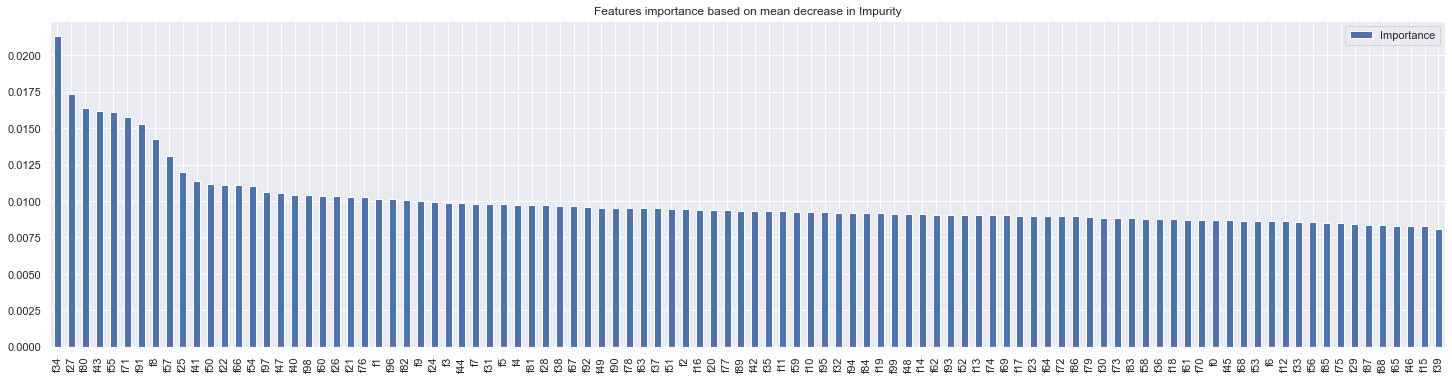

In [48]:
###### 3) Tree-based features selection
rf = RandomForestClassifier().fit(X_train, y_train)

# Mean decrease in Impurity
feat_imp_df = pd.DataFrame(rf.feature_importances_, index=X_train.columns, columns=["Importance"])
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)
feat_imp_df.plot(kind='bar', figsize=(25,6))
plt.title("Features importance based on mean decrease in Impurity");

In [49]:
selectedRF = feat_imp_df[feat_imp_df["Importance"] > 0.010]
selectedRF = list(selectedRF.index)
print(f"{len(selectedRF)} features with importance score > 0.010 selected by Tree-based method: {selectedRF}")

27 features with importance score > 0.010 selected by Tree-based method: ['f34', 'f27', 'f80', 'f43', 'f55', 'f71', 'f91', 'f8', 'f57', 'f25', 'f41', 'f50', 'f22', 'f66', 'f54', 'f97', 'f47', 'f40', 'f98', 'f60', 'f26', 'f21', 'f76', 'f1', 'f96', 'f82', 'f9']


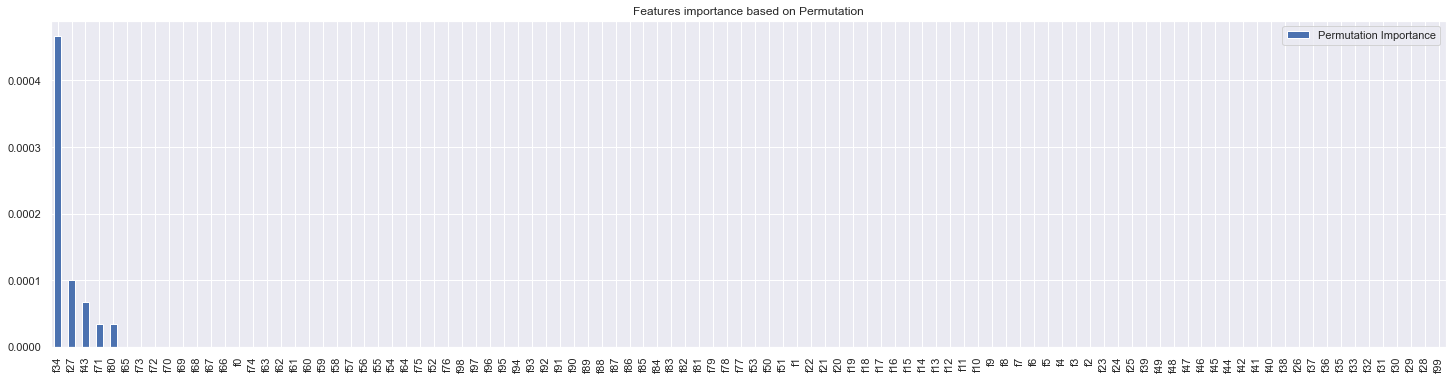

In [50]:
# Feature permutation
from sklearn.inspection import permutation_importance

result_perm = permutation_importance(rf, X_train, y_train, n_repeats=5, random_state=55)

perm_import = pd.DataFrame(result_perm.importances_mean, index=X_train.columns, columns=["Permutation Importance"])
perm_import = perm_import.sort_values(by='Permutation Importance', ascending=False)
perm_import.plot(kind='bar', figsize=(25,6))
plt.title("Features importance based on Permutation");

In [51]:
selectedRF_2 = perm_import[perm_import["Permutation Importance"] > 0]
selectedRF_2 = list(selectedRF_2.index)
print(f"{len(selectedRF_2)} features with importance score > 0 selected by Permutation Tree-based method: {selectedRF_2}")

5 features with importance score > 0 selected by Permutation Tree-based method: ['f34', 'f27', 'f43', 'f71', 'f80']


In [52]:
###### 4) Recursive features elimination (RFE)
from sklearn.feature_selection import RFE

# just as an example, too slow
# rfe = RFE(rf, n_features_to_select=35).fit(X_train, y_train)
# selected_RFE = list(X_train.columns[rfe.get_support()]) 
# print(f"{len(selected_RFE)} Features selected by RFE method: {selected_RFE}")

In [53]:
# Define features to drop
all_features_selected = list(selected_by_all) + selectedRF + selectedRF_2 #+ selected_RFE
feat_to_keep = list(set(all_features_selected))   # eliminate duplicate features, set has no duplicates

print(f"{len(feat_to_keep)} Features selected: {feat_to_keep}")

27 Features selected: ['f71', 'f91', 'f97', 'f43', 'f22', 'f57', 'f82', 'f40', 'f50', 'f8', 'f76', 'f41', 'f26', 'f9', 'f27', 'f1', 'f34', 'f96', 'f80', 'f47', 'f54', 'f98', 'f55', 'f60', 'f25', 'f21', 'f66']


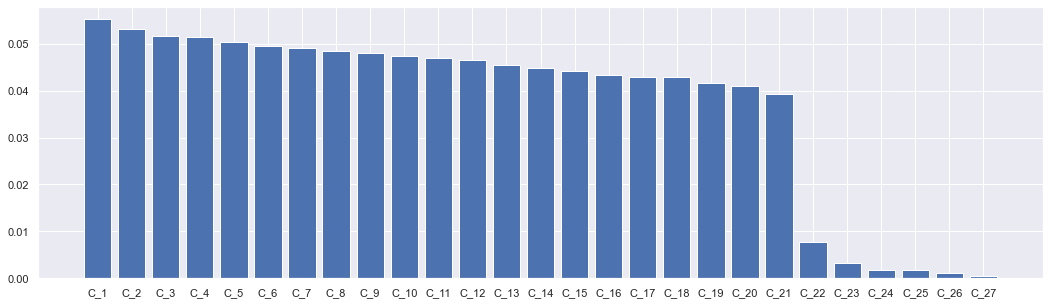

In [54]:
###### 5) PCA on selected features
from sklearn.decomposition import PCA

X_train_fs = X_train[list(feat_to_keep)]

pca = PCA().fit(X_train_fs)

plt.figure(figsize=(18,5))
plt.bar([f"C_{i+1}" for i in range(0, len(feat_to_keep))], pca.explained_variance_ratio_);

# it could be a good option to drop the last 6 principal components

In [57]:
# Drop the last 4 Principal components
components = 21
pca2 = PCA(n_components=components)
X_train_pca = pd.DataFrame(pca2.fit_transform(X_train_fs), columns=[f"C_{i+1}" for i in range(0, components)])
print(f"Explained variance from first {components} Principal Components: {sum(pca2.explained_variance_ratio_)}")

X_train_pca.head(3)

Explained variance from first 21 Principal Components: 0.9837757349212121


,C_1,C_2,C_3,C_4,C_5,C_6,C_7,C_8,C_9,C_10,...,C_12,C_13,C_14,C_15,C_16,C_17,C_18,C_19,C_20,C_21
0,0.010525,0.157471,0.068298,0.409881,0.058154,0.325273,-0.541384,-0.049797,0.023426,0.086572,...,-0.084172,-0.092267,0.105956,0.068242,-0.044095,-0.060679,0.125464,0.566073,0.041905,-0.127962
1,-0.185503,0.146946,0.406323,-0.476955,-0.266860,-0.035338,-0.186967,0.231017,0.108266,0.178990,...,-0.005959,-0.047553,0.131679,-0.440036,0.248859,0.052821,0.318191,-0.177583,0.094053,-0.291150
2,0.165950,-0.024679,-0.108934,0.003578,0.123013,0.222011,-0.346486,-0.057977,0.078327,0.606278,...,-0.222630,0.207081,-0.362664,-0.246731,-0.317582,-0.331465,0.224568,0.179781,-0.098026,-0.000611


### Model selection with nested CV

**!! just an example, 2 models, few hyperparameters**

In [58]:
# Using the functions defined in the file Nested_CrossVal.py
from Nested_CrossVal import inner_CV_setup, nestedCV_model_selection, final_tuning

models = (RandomForestClassifier(), LinearDiscriminantAnalysis())
param_grids = [{"n_estimators": [100, 500], "max_depth": [50, None]}, {"shrinkage": [None]}]
mod_names = ("RandomForest", "LDA")

# prepare the inner cv (stratifiedKfold and GridSearchCV for inner CV)
dict_CVgrids = inner_CV_setup(models, param_grids, mod_names, 3, scoring_metric="roc_auc", seed=33)

# perform nested CV (stratifiedKfold for outer CV)
nestedCV_results = nestedCV_model_selection(dict_CVgrids, 3, X_train_pca, y_train, scoring_metric="roc_auc", seed=22)
nestedCV_results

,LDA,RandomForest
OuterCV_average_Score%,70.594130,69.267192
OuterCV_std%,0.180378,0.939463


### Final tuning for the best model & training for production

Best model with tuned hyperparameters: LinearDiscriminantAnalysis()


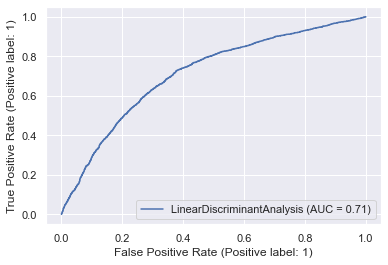

In [59]:
# Identify best model
best_model = LinearDiscriminantAnalysis()
best_grid = [{"shrinkage": [None]}]

# final hyperparams tuning
best_mod_tuned = final_tuning(best_model, best_grid, 4, X_train_pca, y_train, scoring_metric="roc_auc", seed=11)  # stratifiedKfold and GridSearchCV
print(f"Best model with tuned hyperparameters: {best_mod_tuned}")

plot_roc_curve(best_mod_tuned, X_train_pca, y_train);

In [60]:
# Model for production
model_prod = best_mod_tuned.fit(X_train_pca, y_train)
model_prod

LinearDiscriminantAnalysis()